In [9]:
# Importation des librairies



import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "notebook_connected"

import prophet.plot as prophet_plot
prophet_plot.go = go
prophet_plot.make_subplots = make_subplots

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation, performance_metrics

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



In [2]:
# Chargement du CSV
import pandas as pd
import numpy as np

# LOAD & CLEAN 
df = pd.read_csv('Steam_users_10min_last_week.csv', sep=';', encoding='utf-8')

# Dates
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
df = df.dropna(subset=['DateTime'])
df = df.sort_values('DateTime')

# Numériques (enlever séparateurs de milliers éventuels)
for col in ['Users', 'Average Users', 'In-Game']:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(',', '', regex=False)
            .replace({'': np.nan, 'nan': np.nan})
            .astype(float)
        )

# on supprime seulement les NaN sur Users
df = df[df['Users'].notna()]

# drop 'Average Users' car trop manquante
if 'Average Users' in df.columns:
    df = df.drop(columns=['Average Users'])


df = df.set_index('DateTime').sort_index()

# Fréquence cible

freq = 'H'
agg = 'mean'

df_res = df.resample(freq).agg({'Users': agg, **({'In-Game': agg} if 'In-Game' in df.columns else {})})

# Interpolation temporelle des manquants
df_res = df_res.interpolate(method='time')

# Gestion des outliers extrêmes
q_low, q_high = df_res['Users'].quantile([0.001, 0.999])
df_res['Users'] = df_res['Users'].clip(lower=q_low, upper=q_high)

print(df_res.head())
print(df_res.dtypes)

# LOG-TRANSFORM pour stabiliser la variance  car ADF non stationnaire
df_res['Users_log'] = np.log1p(df_res['Users'])

#  Préparation Prophet (colonnes ds/y) 
df_prophet = df_res[['Users']].reset_index().rename(columns={'DateTime': 'ds', 'Users': 'y'})




                            Users  In-Game
DateTime                                  
2004-01-13 00:00:00  85845.981015      NaN
2004-01-13 01:00:00  85845.981015      NaN
2004-01-13 02:00:00  85845.981015      NaN
2004-01-13 03:00:00  85845.981015      NaN
2004-01-13 04:00:00  85845.981015      NaN
Users      float64
In-Game    float64
dtype: object


/tmp/ipykernel_2433/3562754743.py:39: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



In [ ]:
def load_clean_steam(path, date_col="DateTime", y_col="Users",
                     target_freq="H",            # fréquence -> Horaire
                     interp_limit=6,             
                     clip_quantiles=(0.001, 0.999),
                     drop_avg_users=True):
    #  Lecture du CSV
    df = pd.read_csv(
        path, sep=';', quotechar='"', engine='python',
        na_values=['', ' ', 'NA', 'NaN', None], thousands=','
    )
    df.columns = [c.strip().strip('"').strip("'") for c in df.columns]

    # Colonnes utiles
    keep_cols = [date_col, y_col]
    df = df[keep_cols].rename(columns={date_col: "ds", y_col: "y"})
    df["ds"] = pd.to_datetime(df["ds"], errors="coerce", utc=True)  # utc 
    df["y"]  = pd.to_numeric(df["y"], errors="coerce")
    df = (df.dropna(subset=["ds", "y"])
            .drop_duplicates(subset=["ds"], keep="last")
            .sort_values("ds"))

    # Index temporel régulier
    s = df.set_index("ds")["y"].asfreq(target_freq)   
    # Interpolation 
    s = s.interpolate(method="time", limit=interp_limit).bfill().ffill()

    # Outliers 
    q_low, q_high = s.quantile(list(clip_quantiles))
    s = s.clip(lower=q_low, upper=q_high)

    out = s.reset_index().rename(columns={"index": "ds", "y": "y"})
    return out


In [ ]:
# 1) loader en DAILY
df_prophet = load_clean_steam(
    "Steam_users_10min_last_week.csv",
    target_freq="D",           # <= daily pour le long historique
    interp_limit=3,            # trous courts
    clip_quantiles=(0.001,0.999)
)
use_log = False
if use_log:
    df_prophet["y"] = np.log1p(df_prophet["y"])

# Prophet 
from prophet import Prophet
m = Prophet(
    seasonality_mode=("additive" if use_log else "multiplicative"),
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    n_changepoints=30,
    changepoint_prior_scale=0.1,
    changepoint_range=0.9
)
m.add_seasonality(name="monthly", period=30.5, fourier_order=3)

# fit
df_prophet["ds"] = df_prophet["ds"].dt.tz_localize(None)
m.fit(df_prophet)

# forecast
future = m.make_future_dataframe(periods=180, freq="D", include_history=True)
fcst = m.predict(future)

#if use_log:
    #for c in ["yhat","yhat_lower","yhat_upper"]:
        #fcst[c] = np.expm1(fcst[c])

if use_log:
    df_eval['y'] = np.expm1(df_eval['y'])  # OK
    if fcst_eval['yhat'].max() < 100:  
        fcst_eval['yhat'] = np.expm1(fcst_eval['yhat'])




21:05:36 - cmdstanpy - INFO - Chain [1] start processing
21:05:38 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:

# Horizon de prévision = 180 jours 
H = 180  

future = m.make_future_dataframe(periods=H, freq="D", include_history=True)
forecast = m.predict(future)

print(future.tail())
print(fcst[["ds","yhat_lower","yhat","yhat_upper"]].tail())

# Vérif si NaN 
print("NaN rate:", fcst[["yhat_lower","yhat_upper"]].isna().mean())


hist_end = df_prophet["ds"].max()
print("Dernière date historique :", hist_end)
print("Premières dates de prévision :")
print(fcst.loc[fcst["ds"] > hist_end, ["ds","yhat"]].head())
print("Dernières dates de prévision :")
print(fcst.loc[fcst["ds"] > hist_end, ["ds","yhat"]].tail())



             ds
8128 2026-04-15
8129 2026-04-16
8130 2026-04-17
8131 2026-04-18
8132 2026-04-19
             ds    yhat_lower          yhat    yhat_upper
8128 2026-04-15  3.861067e+07  3.990310e+07  4.122724e+07
8129 2026-04-16  3.833135e+07  3.974933e+07  4.109280e+07
8130 2026-04-17  3.921079e+07  4.062159e+07  4.199291e+07
8131 2026-04-18  4.103439e+07  4.254064e+07  4.394035e+07
8132 2026-04-19  4.179139e+07  4.318829e+07  4.453598e+07
NaN rate: yhat_lower    0.0
yhat_upper    0.0
dtype: float64
Dernière date historique : 2025-10-21 00:00:00
Premières dates de prévision :
             ds          yhat
7953 2025-10-22  3.464591e+07
7954 2025-10-23  3.482211e+07
7955 2025-10-24  3.595358e+07
7956 2025-10-25  3.805470e+07
7957 2025-10-26  3.890425e+07
Dernières dates de prévision :
             ds          yhat
8128 2026-04-15  3.990310e+07
8129 2026-04-16  3.974933e+07
8130 2026-04-17  4.062159e+07
8131 2026-04-18  4.254064e+07
8132 2026-04-19  4.318829e+07


In [14]:
# première visualisation (non interactive)
#fig2 = m_month.plot_components(forecast2) 
#fig1 = m_week.plot_components(forecast1) 



In [ ]:

# Affichage avec cônes d’incertitude 
# Série + prévision
import plotly.graph_objects as go
import pandas as pd
hist = df_prophet.copy()            
if use_log:
    hist["y"] = np.expm1(hist["y"])

fc = fcst[["ds","yhat","yhat_lower","yhat_upper"]].copy()


fig = go.Figure()

# historique 
fig.add_trace(go.Scatter(
    x=hist["ds"], y=hist["y"],
    mode="markers",
    name="Historique",
    opacity=0.6,
    marker=dict(size=4)
))

# intervalle
fig.add_trace(go.Scatter(
    x=pd.concat([fc["ds"], fc["ds"][::-1]]),
    y=pd.concat([fc["yhat_upper"], fc["yhat_lower"][::-1]]),
    fill="toself",
    name="Intervalle",
    line=dict(width=0),
    opacity=0.2
))

# yhat
fig.add_trace(go.Scatter(
    x=fc["ds"], y=fc["yhat"],
    mode="lines",
    name="Prévision"
))

fig.update_layout(
    title="Steam Users — Historique & Prévision (linéaire)",
    xaxis_title="Date",
    yaxis_title="Users"
)
fig.show()


In [36]:
# métriques et evaluation


# échelle 
df_eval = df_prophet[['ds','y']].copy()
fcst_eval = fcst[['ds','yhat']].copy()

if use_log:
    df_eval['y'] = np.expm1(df_eval['y'])
    fcst_eval['yhat'] = np.expm1(fcst_eval['yhat'])

# dates (normalisation au jour + suppression timezone)
df_eval['ds'] = pd.to_datetime(df_eval['ds']).dt.tz_localize(None).dt.normalize()
fcst_eval['ds'] = pd.to_datetime(fcst_eval['ds']).dt.tz_localize(None).dt.normalize()

# Merge 
merged = df_eval.merge(fcst_eval, on='ds', how='inner').dropna(subset=['y','yhat'])

print("Nombre de points utilisés pour l'évaluation:", len(merged))

# Extraction
y_true = merged['y'].values
y_pred = merged['yhat'].values

# Calcul des métriques
mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2   = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100

print("Métriques d'évaluation :")
print(f"MAE   : {mae:,.2f}")
print(f"RMSE  : {rmse:,.2f}")
print(f"R²    : {r2:,.4f}")
print(f"MAPE  : {mape:,.2f} %")




Nombre de points utilisés pour l'évaluation: 7953
Métriques d'évaluation :
MAE   : 509,895.45
RMSE  : 980,370.25
R²    : 0.9926
MAPE  : 6.71 %


<Axes: xlabel='ds'>

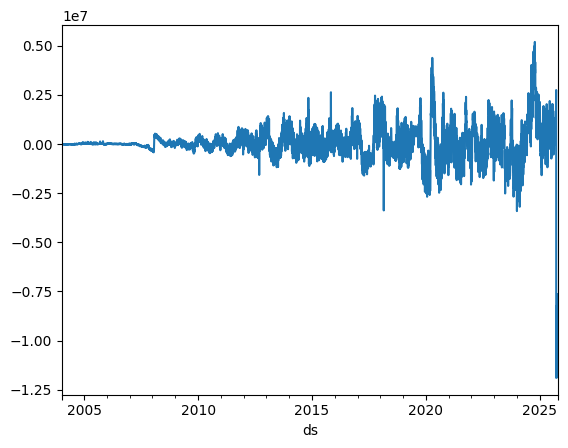

In [31]:
merged['residual'] = merged['y'] - merged['yhat']
merged.set_index('ds')['residual'].plot()


- MAE : En moyenne la prédiction se trompe d'env. 514'000 utilisateurs par jour
- RMSE : erreurs dans les pics/creux en moyenne de 948'000 utilisateurs 
- R2 : le modèle explique 99.26% de la variance -> très bon ajustement global
- MAPE : 7.2% l'erreur relative est de 6.71% donc bonne précision prédictive !




Si on veut aller plus loin on peux faire de l'hyperparameter tuning avec les tendances -> changepoint_prior_scale ou encore ajouter la saisonnalité journalière. 

On joit que juste avec dayly saisonnality = true on gagne 1% de MAPE env.

Je sais pas si on peut tune d'autres params...